In [1]:
!pip install monai==1.3.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 20.6 MB/s eta 0:00:00


In [2]:
import os
import tempfile
import glob
import random
import numpy as np
import gc
import uuid
import pickle
import time
import re

import nibabel as nib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn.model_selection import train_test_split

from monai.utils import set_determinism, first
from monai.data import DataLoader, Dataset, CacheDataset, decollate_batch
from monai.transforms import *
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric, ConfusionMatrixMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference

import torch.nn.functional as F
import torch

2024-08-22 02:28:51.179180: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-22 02:28:51.179303: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-22 02:28:51.305591: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Init

In [3]:
set_determinism(seed=0)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
limited = False

num_labels = 3

In [4]:
data_dir = '/kaggle/input/liver-segmentation-dataset/Task03_Liver'
# data_dir = 'Task03_Liver'
data_file_extension = "*.nii"
# data_file_extension = "*.nii.gz"

In [5]:
sample_id = 0

# Train, Val and Test paths

In [6]:
sample_dict = [{"image": glob.glob(os.path.join(data_dir, "imagesTr", data_file_extension))[sample_id], "label": glob.glob(os.path.join(data_dir, "labelsTr", data_file_extension))[sample_id], "meta_data": {"image_path":glob.glob(os.path.join(data_dir, "imagesTr", data_file_extension))[sample_id], "label_path":glob.glob(os.path.join(data_dir, "labelsTr", data_file_extension))[sample_id],}}]
if limited:
    train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", data_file_extension)))[:5]
    train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", data_file_extension)))[:5]
else:
    train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", data_file_extension)))
    train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", data_file_extension)))
data_dict = [{"image": image_name, "label": label_name, "meta_data": {"image_path":image_name, "label_path":label_name,}} for image_name, label_name in zip(train_images, train_labels)]

In [7]:
if limited:
    train_dict, val_dict = train_test_split(data_dict, test_size=0.4, random_state=42)
    val_dict, test_dict = train_test_split(val_dict, test_size=0.01, random_state=42)
else:
    train_dict, val_dict = train_test_split(data_dict, test_size=0.3, random_state=42)
    val_dict, test_dict = train_test_split(val_dict, test_size=0.4, random_state=42)

In [8]:
print(len(train_dict), len(val_dict), len(test_dict))

91 24 16


# Augmenting and Preprocessing

In [9]:
class MapValues(MapTransform):
    def __init__(self, keys, from_value=None, to_value=None, allow_missing_keys=False):
        super().__init__(keys, allow_missing_keys)
        self.from_value = from_value
        self.to_value = to_value
    
    def __call__(self, data):
        if self.from_value==None or self.to_value==None:
            return d
        d = dict(data)
        for key in self.keys:
            if key in d:
                d[key] = np.where(d[key] == self.from_value, self.to_value, d[key])
        return d

In [10]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-70, #Check range
            a_max=120,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2), mode=("bilinear", "nearest")),
#         SpatialPadd(keys=["image", "label"], spatial_size=(128, 128, 128)),
#         RandCropByPosNegLabeld(
#             keys=["image", "label"],
#             label_key="label",
#             spatial_size=(128, 128, 128),
#             pos=1,
#             neg=1,
#             num_samples=4,
#             image_key="image",
#             image_threshold=0,
#         ),
#         # MapValues(keys=['label'], from_value=2, to_value=1),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-70, #Check range
            a_max=120,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2), mode=("bilinear", "nearest")),
#         SpatialPadd(keys=["image", "label"], spatial_size=(128, 128, 128)),
#         RandCropByPosNegLabeld(
#             keys=["image", "label"],
#             label_key="label",
#             spatial_size=(128, 128, 128),
#             pos=1,
#             neg=1,
#             num_samples=4,
#             image_key="image",
#             image_threshold=0,
#         ),
#         # MapValues(keys=['label'], from_value=2, to_value=1),
    ]
)
test_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-70, #Check range
            a_max=120,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2), mode=("bilinear", "nearest")),
#         SpatialPadd(keys=["image", "label"], spatial_size=(128, 128, 128)),
#         RandCropByPosNegLabeld(
#             keys=["image", "label"],
#             label_key="label",
#             spatial_size=(128, 128, 128),
#             pos=1,
#             neg=1,
#             num_samples=4,
#             image_key="image",
#             image_threshold=0,
#         ),
#         # MapValues(keys=['label'], from_value=2, to_value=1),
    ]
)

/opt/conda/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


## Sanity check

# Data Sets and Data loaders 

In [11]:
train_ds = CacheDataset(data=train_dict, transform=train_transforms, cache_rate=1.0, num_workers=4)
val_ds = CacheDataset(data=val_dict, transform=val_transforms, cache_rate=1.0, num_workers=4)
test_ds = CacheDataset(data=test_dict, transform=test_transforms, cache_rate=1.0, num_workers=4)

Loading dataset: 100%|██████████| 16/16 [01:07<00:00,  4.23s/it]


In [12]:
train_loader = DataLoader(train_ds, batch_size=1, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=1, num_workers=4)

# Utility Functions

In [13]:
def get_recent_checkpoint(dir_path, idx=0, ):
    paths = glob.glob(dir_path+'/*')
    
    if len(paths)==0:
        print('UUID not found')
        return None, None
    
    a = []
    print(paths)
    for path in paths:
        data_file = path.split('/')[-1]
        epoch = re.findall(r'\d+', data_file)
        a.append(int(epoch[0]))
   
    if len(a)>0:
        recent_epoch = sorted(a, reverse=True)[idx]
    else:
        return None, None
   
    return recent_epoch, f'{dir_path}/data_{recent_epoch}.pkl'

In [14]:
def show_plane(ax, plane, cmap="gray", title=None, mask=True):
    if not mask: 
        ax.imshow(plane, cmap=cmap)
    else:
        colors = ["black", "green", "red"]
        cmap = ListedColormap(colors)
        boundaries = [-0.5, 0.5, 1.5, 2.5]
        norm = BoundaryNorm(boundaries, cmap.N, clip=True)
        ax.imshow(plane.astype(float), cmap=cmap, norm=norm, interpolation='nearest')
        
    ax.axis("off")
    if title:
        ax.set_title(title)


# Complete (200 epochs) statistics

In [15]:
idx, checkpoint_path = get_recent_checkpoint(dir_path='/kaggle/input/patch-smodel-aug-cp/6103f738-9d8a-481a-86e4-a02f5bd55862', idx=0)

print("No checkpoint found" if checkpoint_path == None else "Checkpoint found")
print(idx, checkpoint_path)

checkpoint_data = None

if checkpoint_path!=None:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     with open(checkpoint_path, 'rb') as fp:
#         best_checkpoint_data = pickle.load(fp)

    best_checkpoint_data = torch.load(checkpoint_path, map_location=device)

    config = best_checkpoint_data['config']
    
    exclude_list = ['config', 'net_state_dict', 'optimizer_state_dict']
    
    checkpoint_data = {}
    
    for i in best_checkpoint_data.keys():
        if i not in exclude_list:
            checkpoint_data[i] = best_checkpoint_data[i]

['/kaggle/input/patch-smodel-aug-cp/6103f738-9d8a-481a-86e4-a02f5bd55862/data_199.pkl', '/kaggle/input/patch-smodel-aug-cp/6103f738-9d8a-481a-86e4-a02f5bd55862/data_180.pkl', '/kaggle/input/patch-smodel-aug-cp/6103f738-9d8a-481a-86e4-a02f5bd55862/data_136.pkl', '/kaggle/input/patch-smodel-aug-cp/6103f738-9d8a-481a-86e4-a02f5bd55862/data_140.pkl']
Checkpoint found
199 /kaggle/input/patch-smodel-aug-cp/6103f738-9d8a-481a-86e4-a02f5bd55862/data_199.pkl


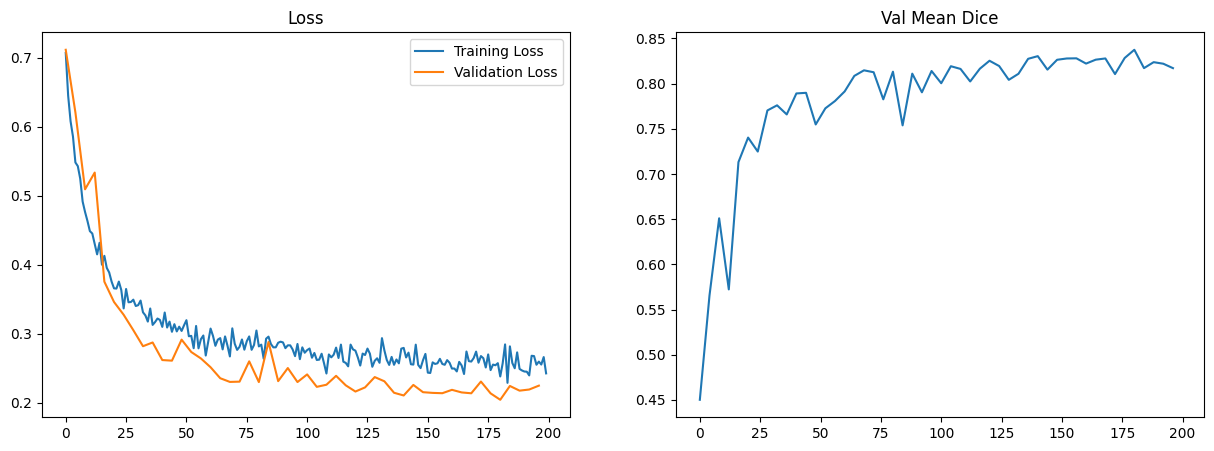

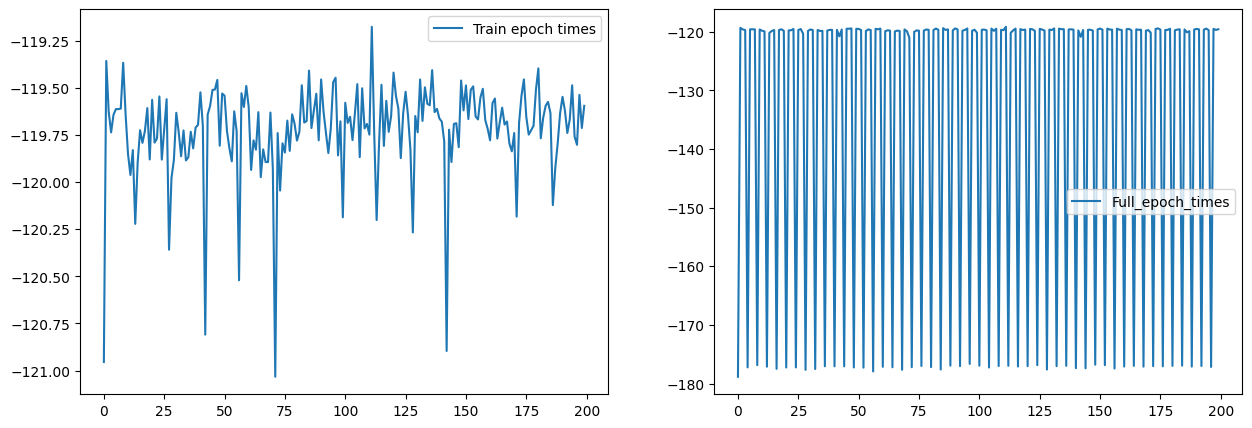

In [16]:
per_epoch_loss = checkpoint_data['per_epoch_loss']
per_epoch_vloss = checkpoint_data['per_epoch_vloss']
metrics = checkpoint_data['metrics']
train_epoch_times = checkpoint_data['train_epoch_times']
full_epoch_times = checkpoint_data['full_epoch_times']
test_interval = config['test_interval']

_, (a, b) = plt.subplots(ncols=2, figsize=(15, 5), sharex=True)

a.plot(per_epoch_loss, label='Training Loss')
a.plot(list(range(0,len(per_epoch_vloss)*test_interval,test_interval)), per_epoch_vloss, label='Validation Loss')
a.set_title('Loss')
# a.xlabel('Epochs')
# a.ylabel('Loss')
a.legend()

b.plot(list(range(0,len(per_epoch_vloss)*test_interval,test_interval)), metrics, label='Val Mean Dice')
b.set_title('Val Mean Dice')
# b.xlabel('Epochs')
# b.ylabel('Val Mean Dice')

_, (a, b) = plt.subplots(ncols=2, figsize=(15, 5), sharex=True)

a.plot( train_epoch_times, label='Train epoch times')
a.legend()

b.plot( full_epoch_times, label='Full_epoch_times')
b.legend()

In [17]:
# print(len(per_epoch_loss))
# print(len(per_epoch_vloss))
# print(len(metrics))
# print(len(train_epoch_times))
# print(len(full_epoch_times))

# Best model

In [18]:
idx, checkpoint_path = get_recent_checkpoint(dir_path='/kaggle/input/patch-smodel-aug-cp/6103f738-9d8a-481a-86e4-a02f5bd55862', idx=1)

print("No checkpoint found" if checkpoint_path == None else "Checkpoint found")
print(idx, checkpoint_path)

checkpoint_data = None

if checkpoint_path!=None:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     with open(checkpoint_path, 'rb') as fp:
#         best_checkpoint_data = pickle.load(fp)

    best_checkpoint_data = torch.load(checkpoint_path, map_location=device)
    
    config = best_checkpoint_data['config']
    
    exclude_list = ['config', 'net_state_dict', 'optimizer_state_dict']
    
    checkpoint_data = {}
    
    for i in best_checkpoint_data.keys():
        if i not in exclude_list:
            checkpoint_data[i] = best_checkpoint_data[i]

['/kaggle/input/patch-smodel-aug-cp/6103f738-9d8a-481a-86e4-a02f5bd55862/data_199.pkl', '/kaggle/input/patch-smodel-aug-cp/6103f738-9d8a-481a-86e4-a02f5bd55862/data_180.pkl', '/kaggle/input/patch-smodel-aug-cp/6103f738-9d8a-481a-86e4-a02f5bd55862/data_136.pkl', '/kaggle/input/patch-smodel-aug-cp/6103f738-9d8a-481a-86e4-a02f5bd55862/data_140.pkl']
Checkpoint found
180 /kaggle/input/patch-smodel-aug-cp/6103f738-9d8a-481a-86e4-a02f5bd55862/data_180.pkl


In [19]:
print('Using device:', device)

# Metric
dice_metric = DiceMetric(reduction="none", return_with_label=True)
recall_metric = ConfusionMatrixMetric(metric_name='recall', reduction="none")
f1_metric = ConfusionMatrixMetric(metric_name='f1 score', reduction="none")
precision_metric = ConfusionMatrixMetric(metric_name='precision', reduction="none")

# Model
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=config['out_channels'],
    channels=config['channels'],
    strides=config['strides'],
    num_res_units=config['depth']-1,
    norm=Norm.BATCH,
    ).to(device)
    
#Utils
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=num_labels)])
post_label = Compose([AsDiscrete(to_onehot=num_labels)])

#Load weights
model.load_state_dict(best_checkpoint_data["net_state_dict"])
model.eval()
print()

Using device: cuda



In [20]:
to_pred = Compose([AsDiscrete(argmax=True, to_onehot=None)])

# Aggregation Function

In [21]:
def aggregate(metric):
    if type(metric)==list:
        metric = metric[0]
    return zip(np.nanmean(metric.numpy(), axis=0).tolist(), np.nanstd(metric.numpy(), axis=0).tolist())

# Train Set Evaluation

In [22]:
plot_interval=5

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Dice for 0: 0.998 +/- 0.003
Dice for 1: 0.945 +/- 0.045
Dice for 2: 0.718 +/- 0.228
Recall for 0: 0.998 +/- 0.003
Recall for 1: 0.942 +/- 0.069
Recall for 2: 0.713 +/- 0.218
F1 for 0: 0.998 +/- 0.003
F1 for 1: 0.945 +/- 0.045
F1 for 2: 0.661 +/- 0.292
Precision for 0: 0.998 +/- 0.004
Precision for 1: 0.951 +/- 0.028
Precision for 2: 0.713 +/- 0.315


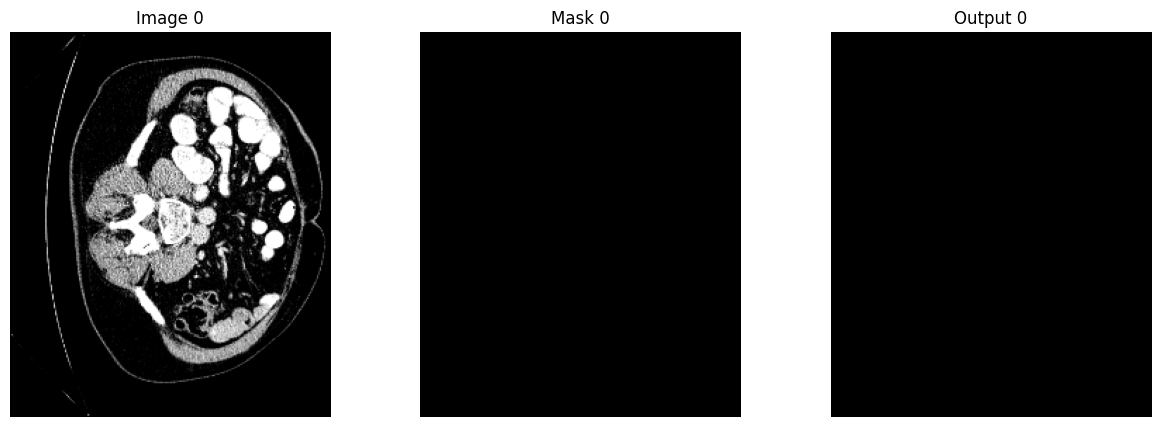

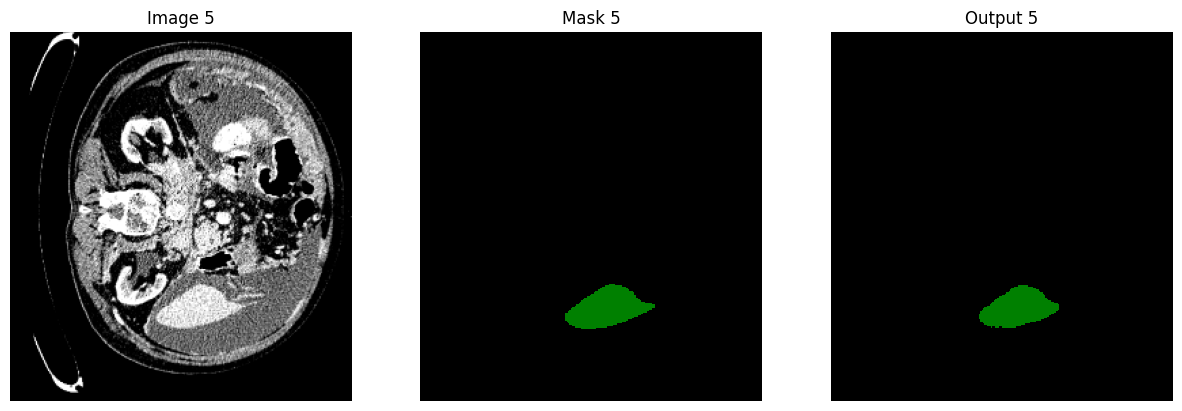

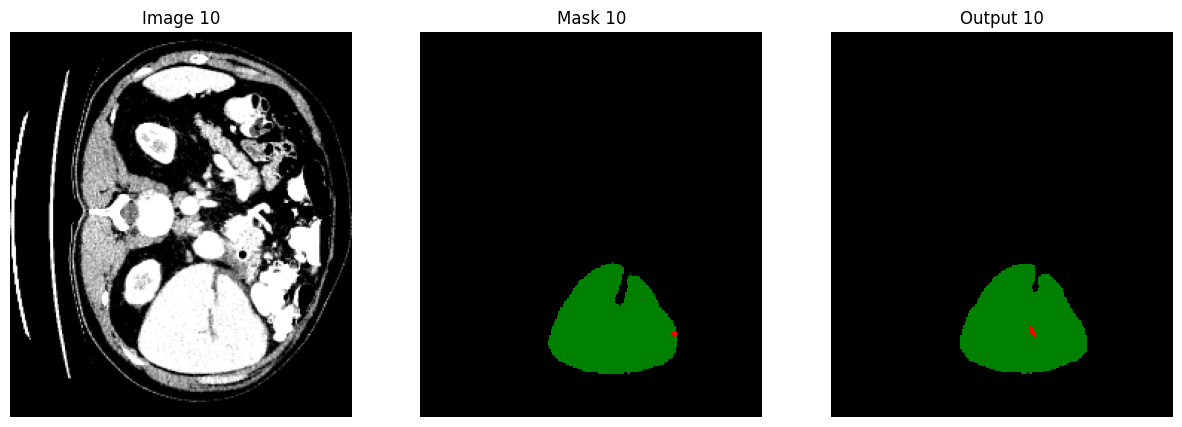

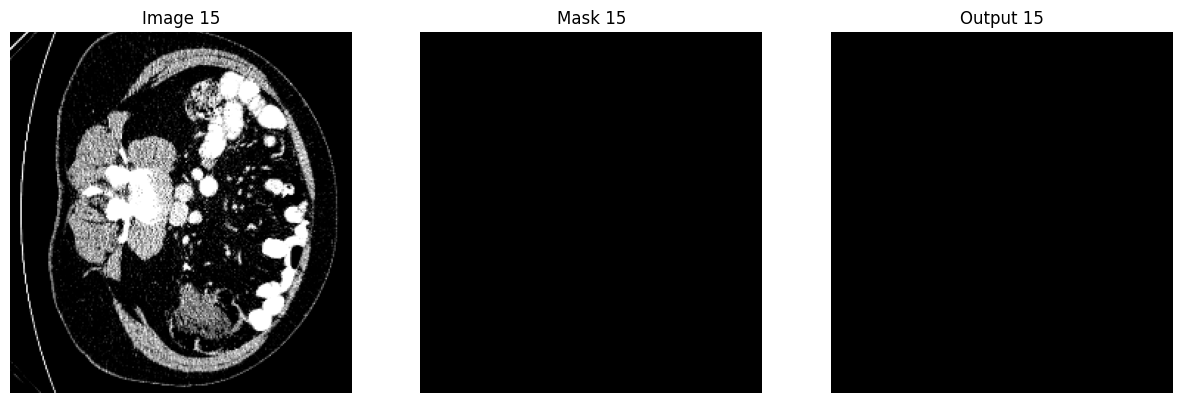

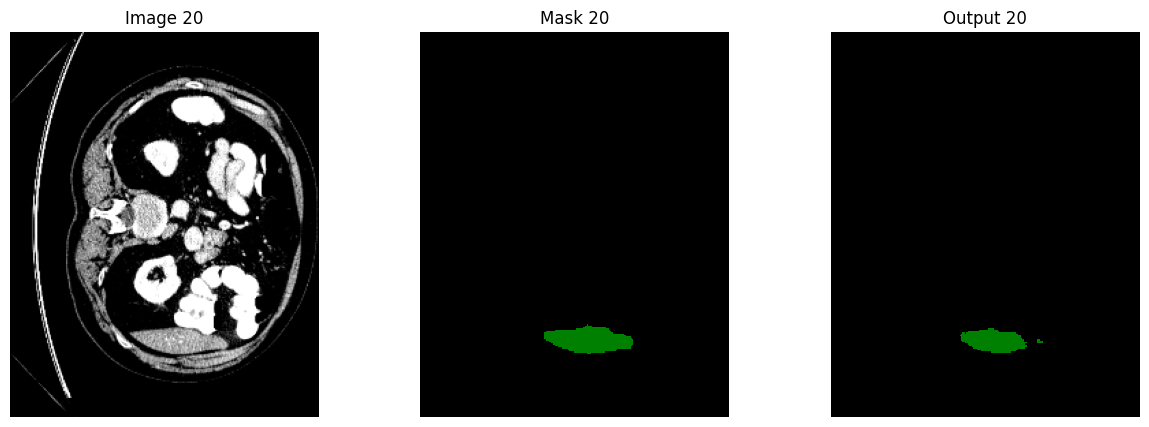

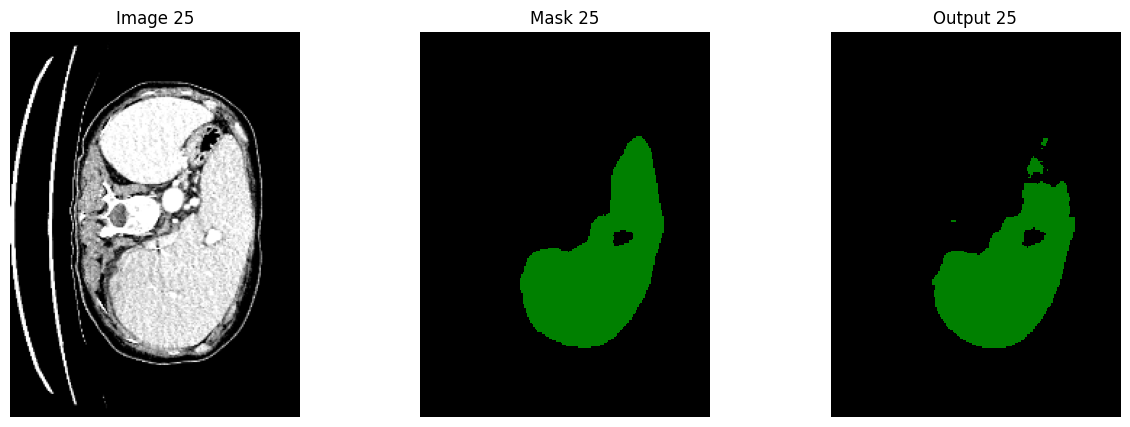

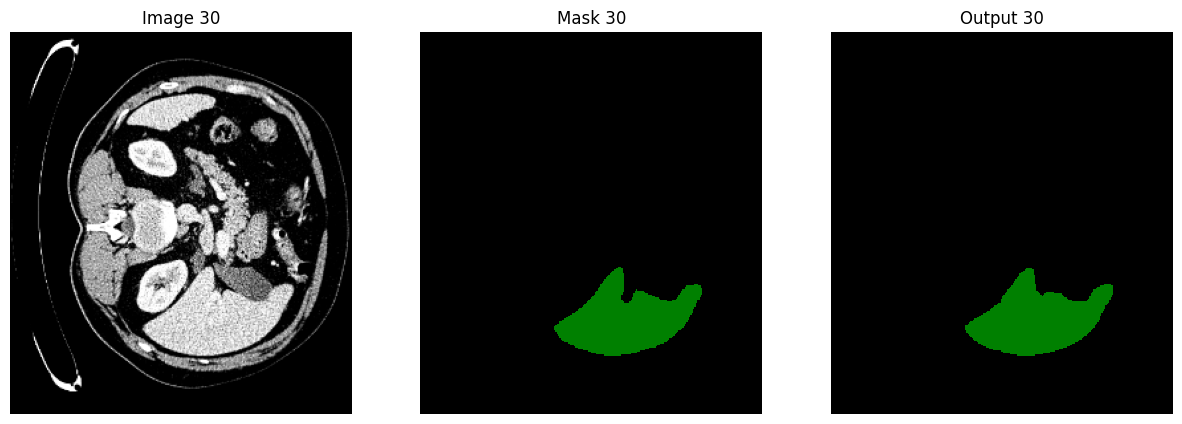

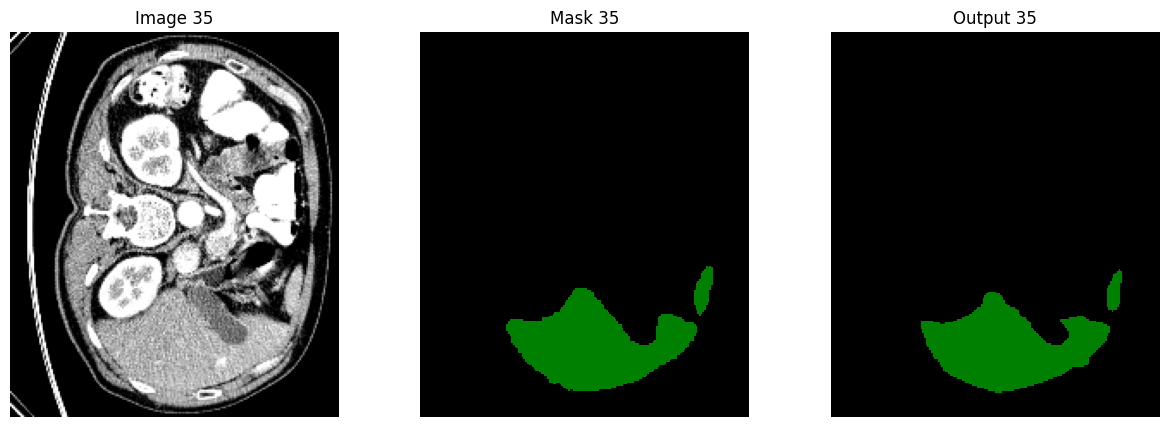

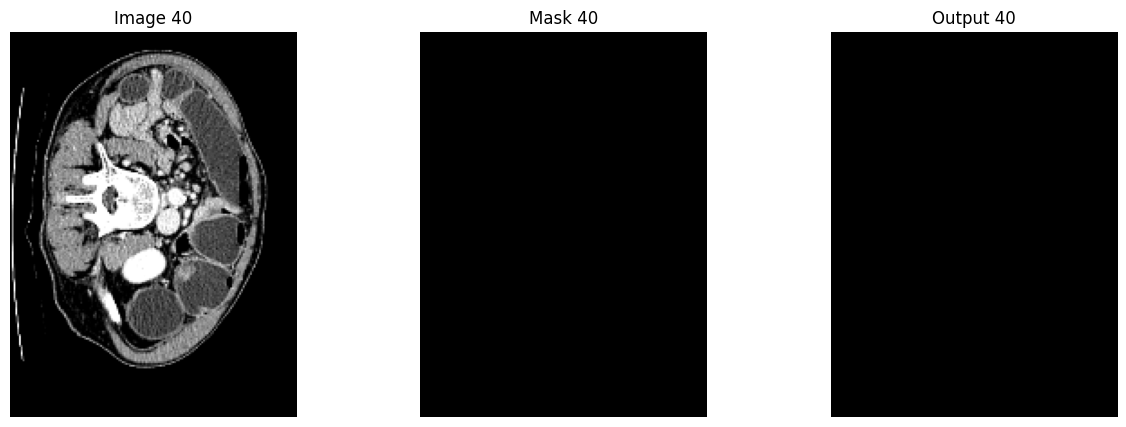

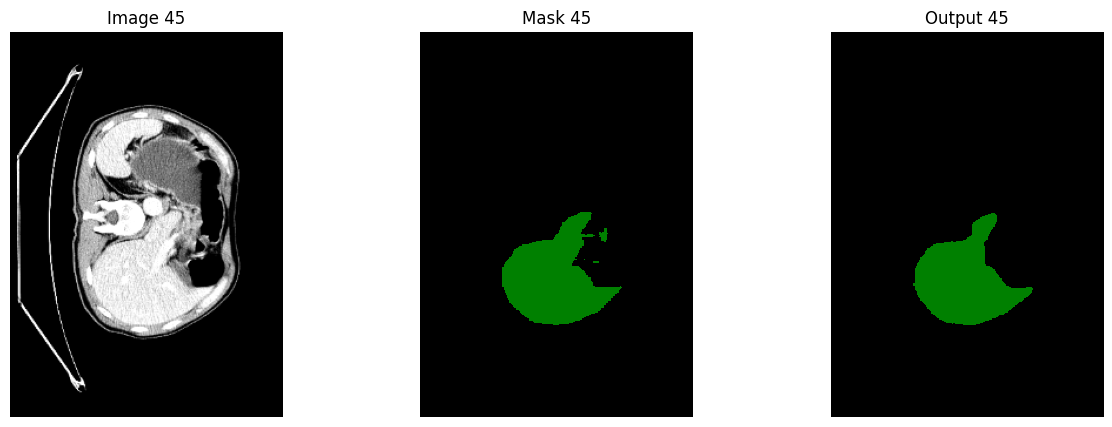

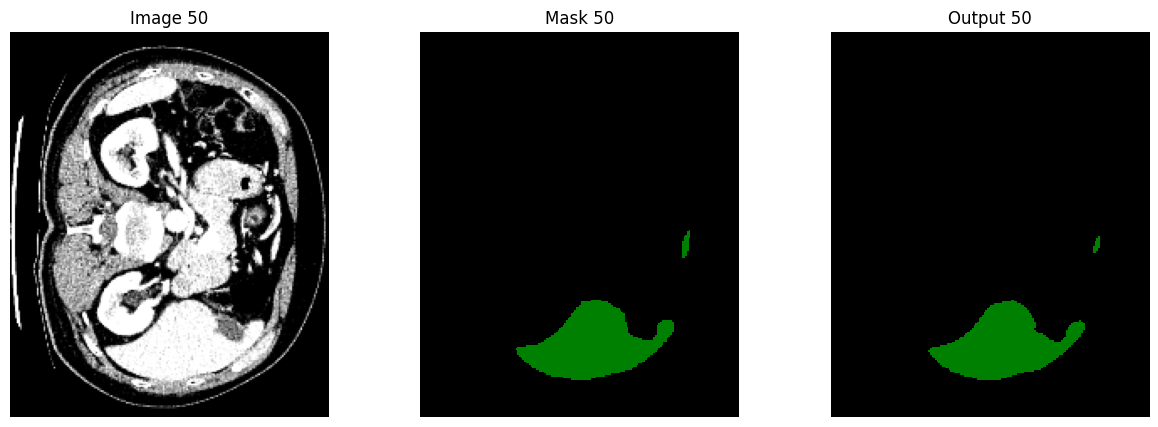

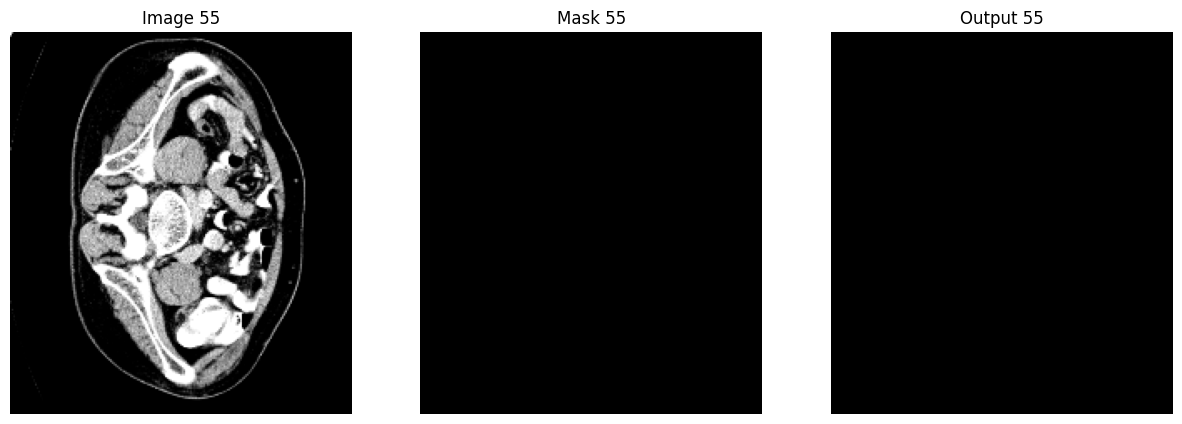

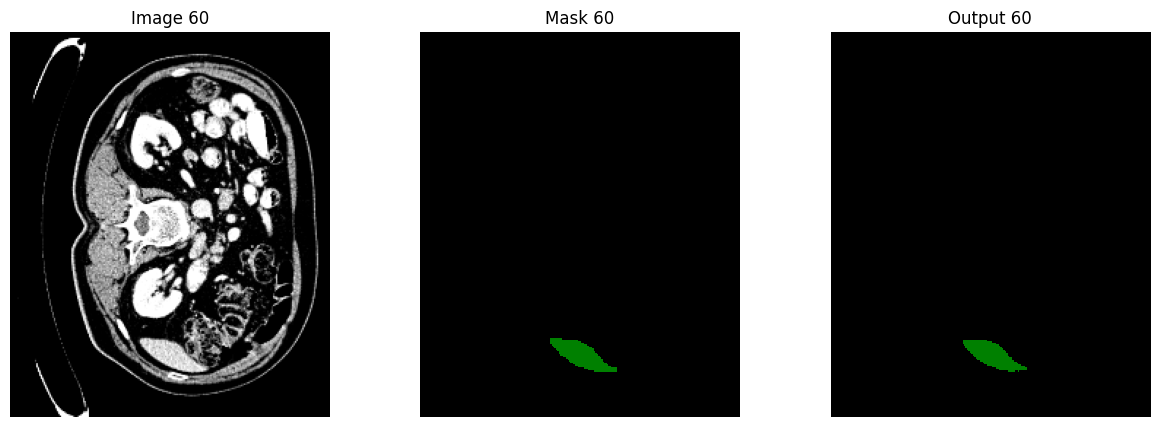

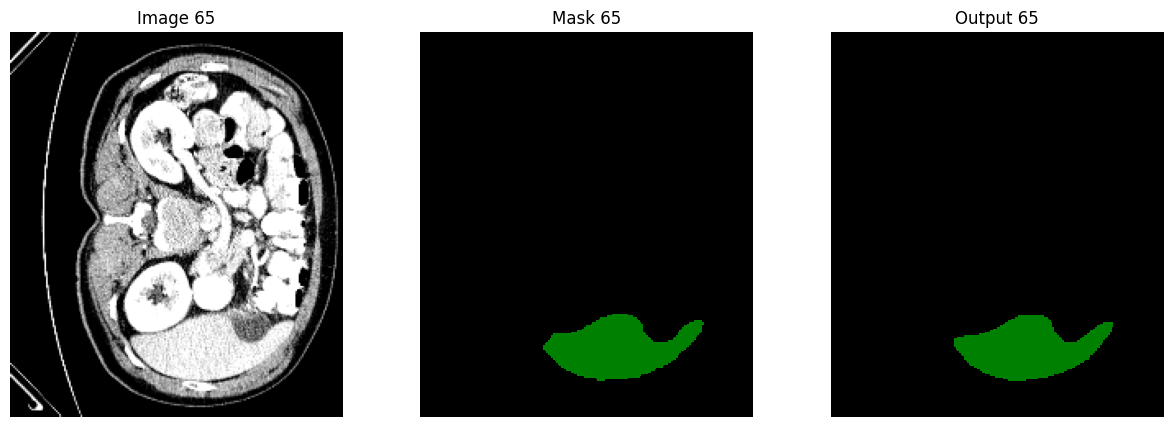

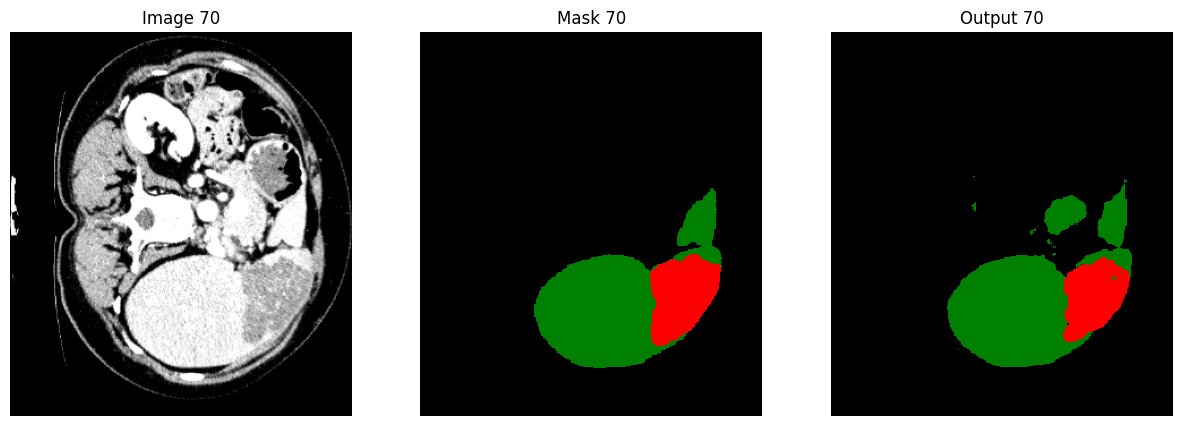

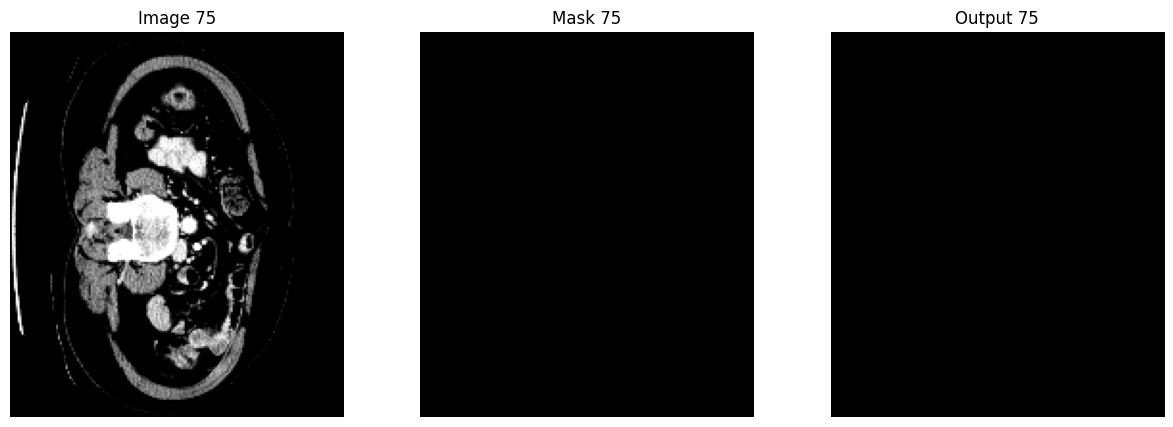

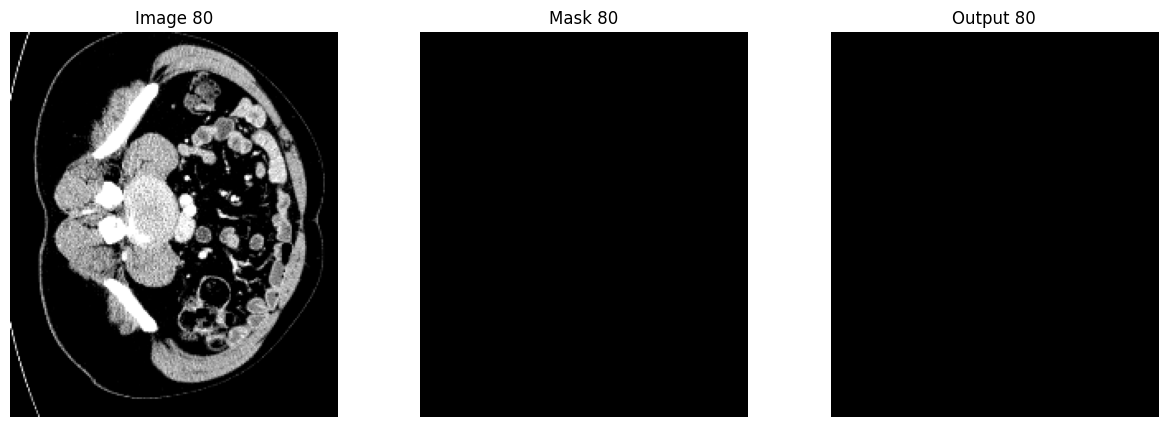

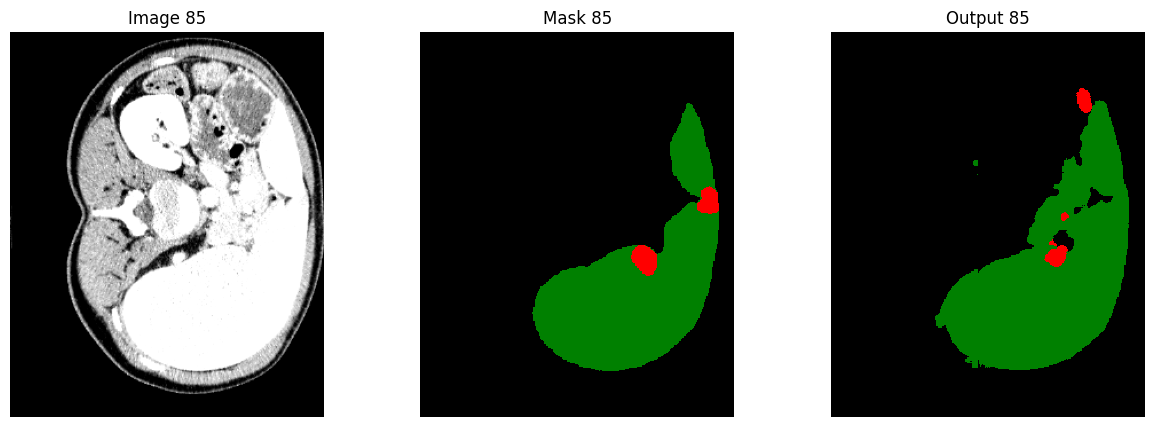

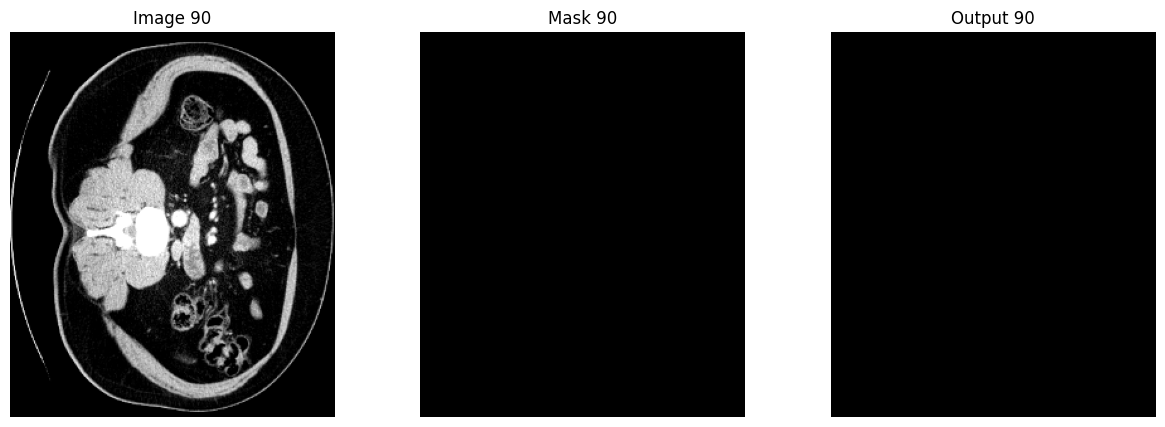

In [23]:
with torch.no_grad():
    for ix, data in enumerate(train_loader):
        roi_size = (128, 128, 128)
        sw_batch_size = 4
        
        outputs = sliding_window_inference(data["image"].to(device), roi_size, sw_batch_size, model, device="cpu", overlap=0)
        
        val_outputs = [post_pred(i) for i in decollate_batch(outputs)]
        val_labels = [post_label(i) for i in decollate_batch(data['label'])]
        
        dice_metric(y_pred=val_outputs, y=val_labels)
        recall_metric(y_pred=val_outputs, y=val_labels)
        f1_metric(y_pred=val_outputs, y=val_labels)
        precision_metric(y_pred=val_outputs, y=val_labels)
        
        if ix%plot_interval==0:
            prediction = [to_pred(i) for i in decollate_batch(outputs)]
        
            _, (a, b, c) = plt.subplots(ncols=3, figsize=(15, 5))

            t = outputs[0].shape[-1]//2
            show_plane(a, data["image"][0,0,:, :, t], title=f'Image {ix}', mask=False)
            show_plane(b, data["label"][0,0,:, :, t], title=f'Mask {ix}') 
            show_plane(c, prediction[0][0][:, :, t], title=f'Output {ix}') 
            
dice_metric_score = aggregate(dice_metric.get_buffer())
dice_metric.reset()
recall_metric_score = aggregate(recall_metric.aggregate())
recall_metric.reset()
f1_metric_score = aggregate(f1_metric.aggregate())
f1_metric.reset()
precision_metric_score = aggregate(precision_metric.aggregate())
precision_metric.reset()

for ix, i in enumerate(dice_metric_score):
    print(f'Dice for {ix}: {i[0]:.3f} +/- {i[1]:.3f}')
for ix, i in enumerate(recall_metric_score):
    print(f'Recall for {ix}: {i[0]:.3f} +/- {i[1]:.3f}')
for ix, i in enumerate(f1_metric_score):
    print(f'F1 for {ix}: {i[0]:.3f} +/- {i[1]:.3f}')
for ix, i in enumerate(precision_metric_score):
    print(f'Precision for {ix}: {i[0]:.3f} +/- {i[1]:.3f}')

# Val Set Evaluation

Dice for 0: 0.999 +/- 0.001
Dice for 1: 0.944 +/- 0.049
Dice for 2: 0.511 +/- 0.279
Recall for 0: 0.999 +/- 0.001
Recall for 1: 0.937 +/- 0.076
Recall for 2: 0.450 +/- 0.293
F1 for 0: 0.999 +/- 0.001
F1 for 1: 0.944 +/- 0.049
F1 for 2: 0.467 +/- 0.303
Precision for 0: 0.998 +/- 0.002
Precision for 1: 0.953 +/- 0.023
Precision for 2: 0.622 +/- 0.347


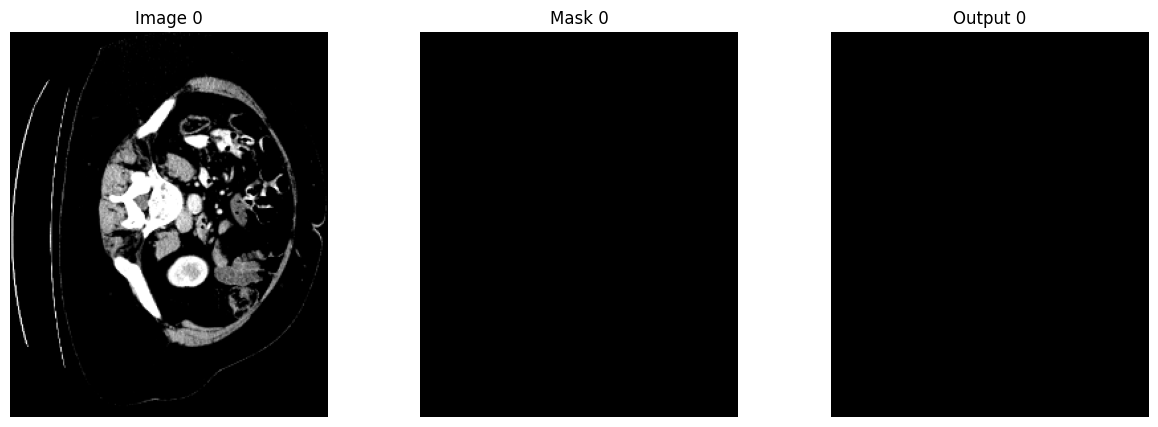

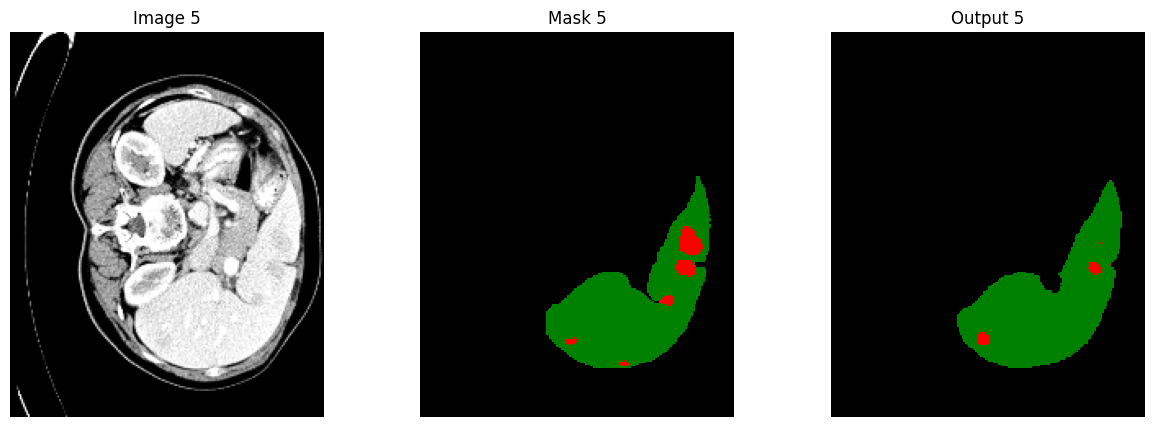

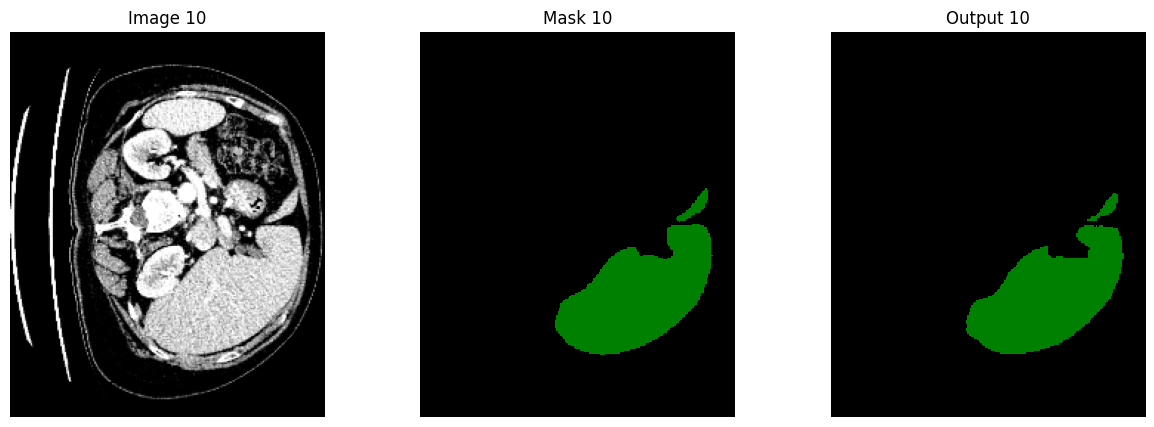

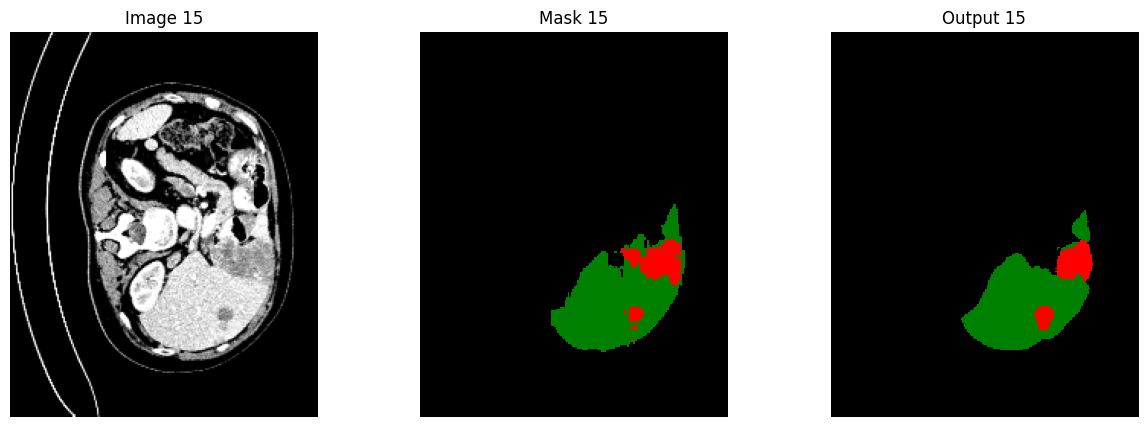

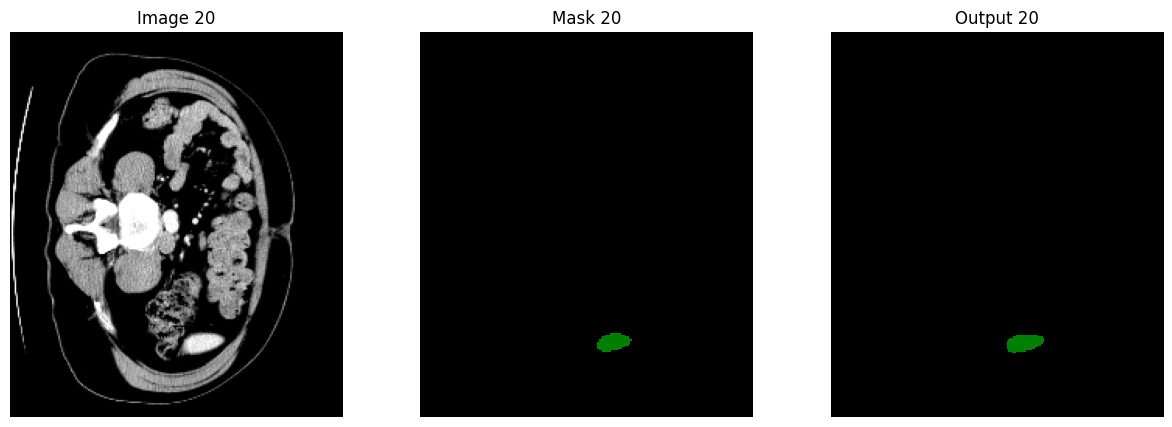

In [24]:
with torch.no_grad():
    for ix, data in enumerate(val_loader):
        roi_size = (128, 128, 128)
        sw_batch_size = 4
        
        outputs = sliding_window_inference(data["image"].to(device), roi_size, sw_batch_size, model, device="cpu", overlap=0)
        
        val_outputs = [post_pred(i) for i in decollate_batch(outputs)]
        val_labels = [post_label(i) for i in decollate_batch(data['label'])]
        
        dice_metric(y_pred=val_outputs, y=val_labels)
        recall_metric(y_pred=val_outputs, y=val_labels)
        f1_metric(y_pred=val_outputs, y=val_labels)
        precision_metric(y_pred=val_outputs, y=val_labels)
        
        if ix%plot_interval==0:
            prediction = [to_pred(i) for i in decollate_batch(outputs)]
        
            _, (a, b, c) = plt.subplots(ncols=3, figsize=(15, 5))

            t = outputs[0].shape[-1]//2
            show_plane(a, data["image"][0,0,:, :, t], title=f'Image {ix}', mask=False)
            show_plane(b, data["label"][0,0,:, :, t], title=f'Mask {ix}') 
            show_plane(c, prediction[0][0][:, :, t], title=f'Output {ix}') 
            
dice_metric_score = aggregate(dice_metric.get_buffer())
dice_metric.reset()
recall_metric_score = aggregate(recall_metric.aggregate())
recall_metric.reset()
f1_metric_score = aggregate(f1_metric.aggregate())
f1_metric.reset()
precision_metric_score = aggregate(precision_metric.aggregate())
precision_metric.reset()

for ix, i in enumerate(dice_metric_score):
    print(f'Dice for {ix}: {i[0]:.3f} +/- {i[1]:.3f}')
for ix, i in enumerate(recall_metric_score):
    print(f'Recall for {ix}: {i[0]:.3f} +/- {i[1]:.3f}')
for ix, i in enumerate(f1_metric_score):
    print(f'F1 for {ix}: {i[0]:.3f} +/- {i[1]:.3f}')
for ix, i in enumerate(precision_metric_score):
    print(f'Precision for {ix}: {i[0]:.3f} +/- {i[1]:.3f}')

# Test Set Evaluation

Dice for 0: 0.996 +/- 0.007
Dice for 1: 0.885 +/- 0.216
Dice for 2: 0.367 +/- 0.316
Recall for 0: 0.998 +/- 0.002
Recall for 1: 0.889 +/- 0.225
Recall for 2: 0.341 +/- 0.307
F1 for 0: 0.996 +/- 0.007
F1 for 1: 0.885 +/- 0.216
F1 for 2: 0.344 +/- 0.319
Precision for 0: 0.993 +/- 0.015
Precision for 1: 0.935 +/- 0.037
Precision for 2: 0.573 +/- 0.416


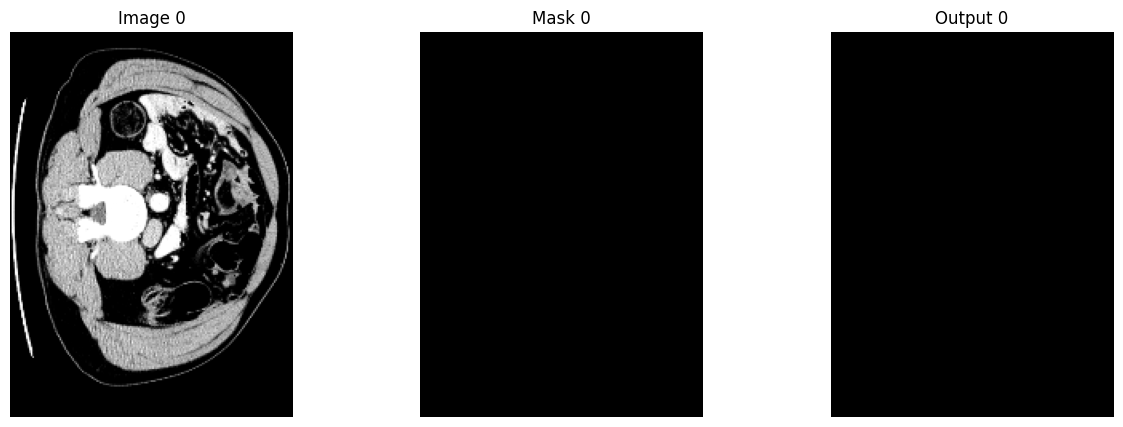

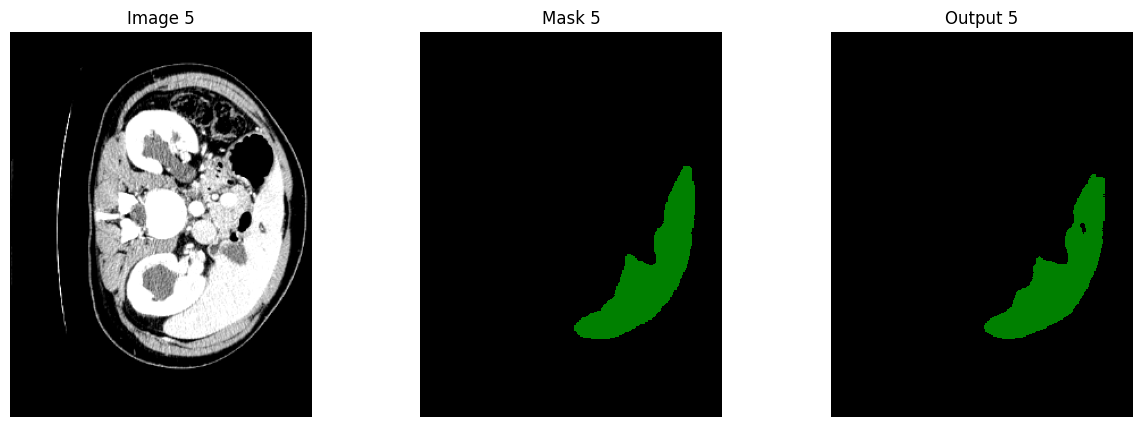

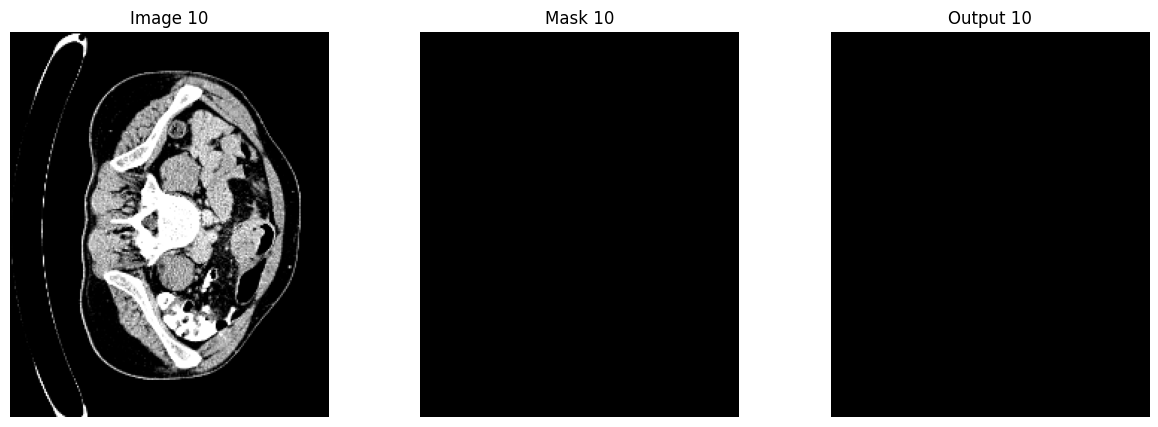

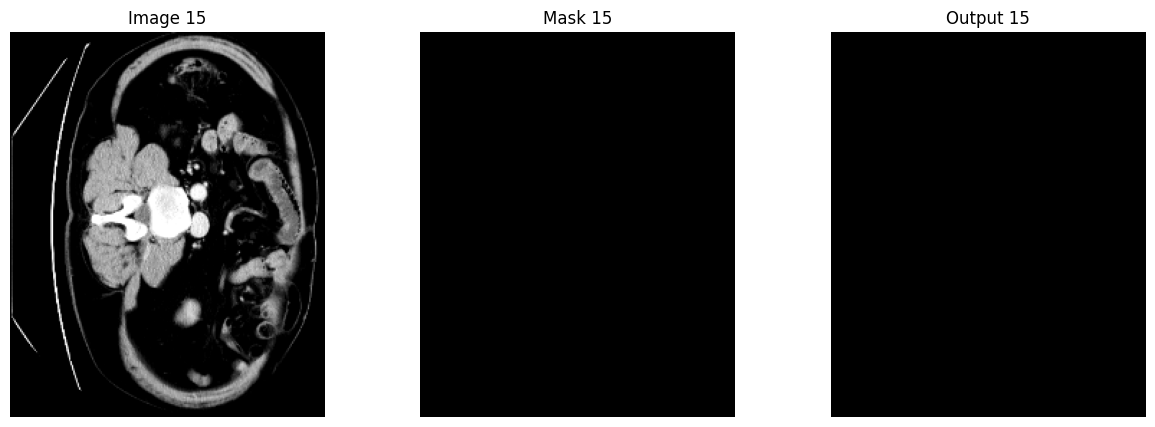

In [25]:
with torch.no_grad():
    for ix, data in enumerate(test_loader):
        roi_size = (128, 128, 128)
        sw_batch_size = 4
        
        outputs = sliding_window_inference(data["image"].to(device), roi_size, sw_batch_size, model, device="cpu", overlap=0)
        
        val_outputs = [post_pred(i) for i in decollate_batch(outputs)]
        val_labels = [post_label(i) for i in decollate_batch(data['label'])]
        
        dice_metric(y_pred=val_outputs, y=val_labels)
        recall_metric(y_pred=val_outputs, y=val_labels)
        f1_metric(y_pred=val_outputs, y=val_labels)
        precision_metric(y_pred=val_outputs, y=val_labels)
        
        if ix%plot_interval==0:
            prediction = [to_pred(i) for i in decollate_batch(outputs)]
        
            _, (a, b, c) = plt.subplots(ncols=3, figsize=(15, 5))

            t = outputs[0].shape[-1]//2
            show_plane(a, data["image"][0,0,:, :, t], title=f'Image {ix}', mask=False)
            show_plane(b, data["label"][0,0,:, :, t], title=f'Mask {ix}') 
            show_plane(c, prediction[0][0][:, :, t], title=f'Output {ix}') 
            
dice_metric_score = aggregate(dice_metric.get_buffer())
dice_metric.reset()
recall_metric_score = aggregate(recall_metric.aggregate())
recall_metric.reset()
f1_metric_score = aggregate(f1_metric.aggregate())
f1_metric.reset()
precision_metric_score = aggregate(precision_metric.aggregate())
precision_metric.reset()

for ix, i in enumerate(dice_metric_score):
    print(f'Dice for {ix}: {i[0]:.3f} +/- {i[1]:.3f}')
for ix, i in enumerate(recall_metric_score):
    print(f'Recall for {ix}: {i[0]:.3f} +/- {i[1]:.3f}')
for ix, i in enumerate(f1_metric_score):
    print(f'F1 for {ix}: {i[0]:.3f} +/- {i[1]:.3f}')
for ix, i in enumerate(precision_metric_score):
    print(f'Precision for {ix}: {i[0]:.3f} +/- {i[1]:.3f}')